In [1]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import numpy as np

import matplotlib.pyplot as plt

from fourierSeries import fourier
from loadData import load_data

order = 250
filename = "../Hello There (Obi Wan) - Sound Effect (HD).wav"
batch_size = 500
initial_learning_rate = 0.0001
gamma = 0.95
sequencer_steps = 1
learning_rate_params = {"initial_learning_rate": initial_learning_rate, "gamma": gamma, "sequencer_steps": sequencer_steps}


In [2]:
# tests for imported modules
print(fourier(10, order))

train_data, train_labels, test_data, test_labels = load_data(filename,order)

# type of train_data
print("train_data")
print(type(train_data))
print(train_data.shape)

# type of train_labels
print("train_labels")
print(type(train_labels))
print(train_labels.shape)

# type of test_data
print("test_data")
print(type(test_data))
print(test_data.shape)

# type of test_labels
print("test_labels")
print(type(test_labels))
print(test_labels.shape)

[10, -0.5440211108893698, -0.8390715290764524, 0.9129452507276277, 0.408082061813392, -0.9880316240928618, 0.15425144988758405, 0.7451131604793488, -0.6669380616522619, -0.26237485370392877, 0.9649660284921133, -0.3048106211022167, -0.9524129804151563, 0.7738906815578891, 0.6333192030862999, -0.9938886539233752, -0.11038724383904756, 0.8939966636005579, -0.4480736161291702, -0.5063656411097588, 0.8623188722876839, -0.044242678085070965, -0.999020813314648, 0.5806111842123143, 0.8141809705265618, -0.9301059501867618, -0.3672913304546965, 0.9802396594403116, -0.19781357400426822, -0.7148764296291646, 0.6992508064783751, 0.21942525837900473, -0.9756293127952373, 0.3466494554970303, 0.9379947521194415, -0.8011526357338304, -0.5984600690578581, 0.9977992786806003, 0.06630685835171127, -0.8732972972139945, 0.4871876750070059, 0.46771851834275896, -0.8838774731823718, 0.08839871248753149, 0.9960851708717215, -0.6160642040533645, -0.787695941645058, 0.9454451549211168, 0.32578130553514806, -0.

In [3]:
# Custom dataset class
class CSVDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


In [4]:
class Net(nn.Module):
    def __init__(self, order):
        super().__init__()
        self.dims = 2*order + 1
        self.fc1 = nn.Linear(self.dims, 2*self.dims)
        self.fc2 = nn.Linear(2*self.dims, 2*self.dims)
        self.fc3 = nn.Linear(2*self.dims, 2*self.dims)
        self.fc4 = nn.Linear(2*self.dims, 2*self.dims)
        self.fc5 = nn.Linear(2*self.dims, 1)


    def forward(self, x):
        x = torch.flatten(x, -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [5]:
# data loader
train_dataset = CSVDataset(train_data, train_labels)
test_dataset = CSVDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
# define the training function

def train(model, train_loader, criterion, optimizer, epochs):
    loss_list = []
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Decrease learning rate by 5% after every 1 epoch
    for epoch in range(epochs+1):
        for input, data in enumerate(train_loader):
            input, labels = data
            labels = labels.unsqueeze(1)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        
        scheduler.step()  # Decrease learning rate

        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + ", Loss: " + str(loss.item()) + ", Learning rate: " + str(scheduler.get_last_lr()))
    print("Epoch: " + str(epoch) + ", Loss: " + str(loss.item()) + ", Learning rate: " + str(scheduler.get_last_lr()))

    # use matplotlib to plot the loss
    plt.figure(figsize=(10,5))
    plt.title("Training Loss over Time")
    plt.plot(loss_list, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
                
    print("Finished Training")

In [15]:
# define the testing function

def test(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f"Accuracy: {correct / total}")

In [16]:
# create an instance of the network
model = Net(order)

print(model.fc1.weight.dtype)
print(model.fc1.bias.dtype)
print(train_data[0].dtype)

# define the loss function and optimizer
criterion = nn.MSELoss()
# could integrate into train function to reduce lr over epochs
# changing the optimizer to Adam
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# run one forward pass on the first item in the train_loader
print(train_labels[0].item())
model.forward(train_data[0])

torch.float32
torch.float32
torch.float32
3.0518509447574615e-05


tensor([0.0236], grad_fn=<AddBackward0>)

Epoch: 0, Loss: 2.15933895111084, Learning rate: [9.5e-05]
Epoch: 10, Loss: 3.503341940813698e-05, Learning rate: [5.688000922764596e-05]
Epoch: 20, Loss: 2.345939356018789e-05, Learning rate: [3.405616262881148e-05]
Epoch: 30, Loss: 1.56661553774029e-05, Learning rate: [2.039068257457904e-05]
Epoch: 40, Loss: 1.18862890303717e-05, Learning rate: [1.2208654873684796e-05]
Epoch: 50, Loss: 9.801965461520012e-06, Learning rate: [7.309772651287749e-06]
Epoch: 60, Loss: 9.626306564314291e-06, Learning rate: [4.3766309037604346e-06]
Epoch: 70, Loss: 7.6084447755420115e-06, Learning rate: [2.6204505914936218e-06]
Epoch: 80, Loss: 7.637682756467257e-06, Learning rate: [1.5689605665762901e-06]
Epoch: 90, Loss: 7.116801953088725e-06, Learning rate: [9.393946474176003e-07]
Epoch: 100, Loss: 7.361004463746212e-06, Learning rate: [5.624502759317298e-07]
Epoch: 110, Loss: 8.23332720756298e-06, Learning rate: [3.367597566851454e-07]
Epoch: 120, Loss: 8.558849913242739e-06, Learning rate: [2.016305059

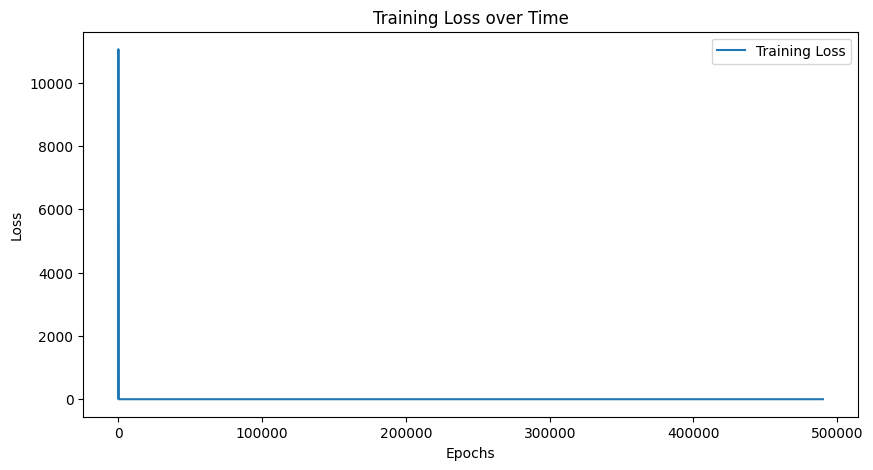

Finished Training
Accuracy: 0.2057998514974012


In [17]:
# train the network
train(model, train_loader, criterion, optimizer, 10000)

# test the network
test(model, test_loader)

In [18]:
print(train_data[100])
print(model.forward(train_data[100]))

print(torch.tensor(fourier(100, order), dtype=torch.float32))
print(model.forward(torch.tensor(fourier(100, order), dtype=torch.float32)))

tensor([ 2.0000e+02, -8.7330e-01,  4.8719e-01, -8.5092e-01, -5.2530e-01,
         4.4182e-02, -9.9902e-01,  8.9397e-01, -4.4813e-01,  8.2688e-01,
         5.6238e-01, -8.8279e-02,  9.9610e-01, -9.1290e-01,  4.0819e-01,
        -8.0122e-01, -5.9836e-01,  1.3220e-01, -9.9122e-01,  9.3004e-01,
        -3.6746e-01,  7.7401e-01,  6.3318e-01, -1.7587e-01,  9.8441e-01,
        -9.4537e-01,  3.2601e-01, -7.4527e-01, -6.6676e-01,  2.1919e-01,
        -9.7568e-01,  9.5885e-01, -2.8392e-01,  7.1509e-01,  6.9904e-01,
        -2.6208e-01,  9.6505e-01, -9.7046e-01,  2.4128e-01, -6.8350e-01,
        -7.2995e-01,  3.0447e-01, -9.5252e-01,  9.8017e-01, -1.9817e-01,
         6.5059e-01,  7.5943e-01, -3.4625e-01,  9.3814e-01, -9.8797e-01,
         1.5467e-01, -6.1640e-01, -7.8744e-01,  3.8736e-01, -9.2193e-01,
         9.9384e-01, -1.1087e-01,  5.8100e-01,  8.1390e-01, -4.2772e-01,
         9.0391e-01, -9.9776e-01,  6.6848e-02, -5.4448e-01, -8.3878e-01,
         4.6724e-01, -8.8413e-01,  9.9974e-01, -2.2

In [19]:
# save the model
torch.save(model.state_dict(), "fourierModel.pt")

In [20]:
# load the model if needed
model = Net(order)
model.load_state_dict(torch.load("fourierModel.pt"))
model.eval()

Net(
  (fc1): Linear(in_features=501, out_features=1002, bias=True)
  (fc2): Linear(in_features=1002, out_features=1002, bias=True)
  (fc3): Linear(in_features=1002, out_features=1002, bias=True)
  (fc4): Linear(in_features=1002, out_features=1002, bias=True)
  (fc5): Linear(in_features=1002, out_features=1, bias=True)
)

In [21]:
from generateWave import generate_wav

new_wav_data = []
for i in range(88200):
    modelInput = torch.tensor(fourier(i, order), dtype=torch.float32)
    new_wav_data.append(model.forward(modelInput).item())
print(len(new_wav_data))
print(new_wav_data[0:10])
print(max(new_wav_data)*32767.0)
print(min(new_wav_data)*32767.0)

generate_wav("new_wav.wav",new_wav_data)



88200
[9.489431977272034e-05, 0.0018464629538357258, 5.8688223361968994e-05, 0.007005646824836731, 3.075040876865387e-05, 0.00038384227082133293, 0.0001049763523042202, 0.00048500578850507736, -5.790684372186661e-05, 0.0015916856937110424]
623.4162159655243
-328.85647990368307
0
9.489431977272034e-05
3
1
0.0018464629538357258
60
2
5.8688223361968994e-05
1
3
0.007005646824836731
229
4
3.075040876865387e-05
1
5
0.00038384227082133293
12
6
0.0001049763523042202
3
7
0.00048500578850507736
15
8
-5.790684372186661e-05
-1
9
0.0015916856937110424
52
10
2.8284266591072083e-05
0
11
-0.0013150512240827084
-43
12
-4.896428436040878e-05
-1
13
-0.0007135062478482723
-23
14
0.0001038513146340847
3
15
0.0021090107038617134
69
16
4.82671894133091e-05
1
17
0.002449901308864355
80
18
9.862380102276802e-05
3
19
0.001731447409838438
56
20
1.796521246433258e-06
0
21
0.01277085579931736
418
22
4.6584755182266235e-05
1
23
-0.0015208949334919453
-49
24
0.0005364934913814068
17
25
0.006049744319170713
198
26
0.